In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

## SIFT function

class KeyPoint {

     Point2f  pt;  坐标  
     float  size; 特征点邻域直径  
     float  angle; 特征点的方向，值为[零,三百六十)，负值表示不使用  
     float  response;  
     int  octave; 特征点所在的图像金字塔的组  
     int  class_id; 用于聚类的id  
}; 

* SIFT no longer available in opencv > 3.4.2
* reinstall opencv
* pip install opencv-python == 3.4.2.16
* pip install opencv-contrib-python == 3.4.2.16

In [2]:
def SIFT(img1_path, img2_path):
    img1 = cv2.imread(img1_path) # queryImage
    img2 = cv2.imread(img2_path) # trainImage
    gray1 = cv2.imread(img1_path,0)
    gray2 = cv2.imread(img2_path,0)
    while(img2.shape[0] > 1000):
        if img1.shape == img2.shape:
            img1 = cv2.resize(img1,None,fx=0.5, fy=0.5)
            gray1 = cv2.resize(gray1,None,fx=0.5, fy=0.5)
        img2 = cv2.resize(img2,None,fx=0.5, fy=0.5)
        gray2 = cv2.resize(gray2,None,fx=0.5, fy=0.5)




    # Initiate SIFT detector

    sift = cv2.xfeatures2d.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(gray1,None)
    kp2, des2 = sift.detectAndCompute(gray2,None)
    return img1, img2, kp1, kp2, des1, des2

* SIFT function result (just for test)

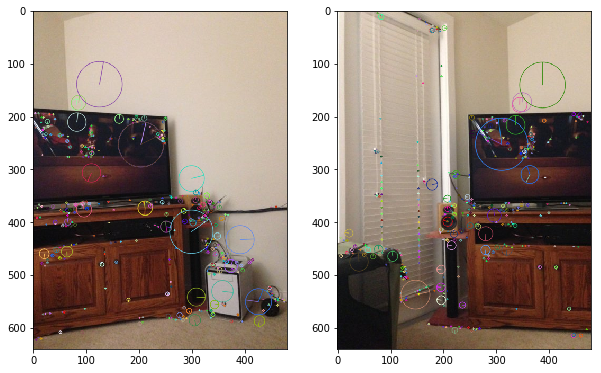

In [3]:
img1_path = './data/2.jpg'
img2_path = './data/1.jpg'
img1, img2, kp1, kp2, des1, des2 = SIFT(img1_path, img2_path)
sift_img1 = cv2.drawKeypoints(img1[:,:,::-1],kp1,np.array([]),flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
sift_img2 = cv2.drawKeypoints(img2[:,:,::-1],kp2,np.array([]),flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(sift_img1)
plt.subplot(122)
plt.imshow(sift_img2);

# function

In [6]:
def match(img1_path, img2_path, ratio = 0.5, show = False):
    img1, img2, kp1, kp2, des1, des2 = SIFT(img1_path, img2_path)

    match = []
    for i in range(des1.shape[0]):
        
        des1_ = np.tile(des1[i], (des2.shape[0], 1))
        error = des1_ - des2
        SSD = np.sum((error**2), axis=1)
        idx_sort = np.argsort(SSD)
        if SSD[idx_sort[0]] < ratio * SSD[idx_sort[1]]:
            match.append([kp1[i].pt, kp2[idx_sort[0]].pt])
    line = np.array(match)
    
    #draw result after match
    if show:
        print('match points with ratio = {}'.format(ratio))
        keyPoint1, keyPoint2 = line[:, 0], line[:, 1]
        showMatch(img1, img2, keyPoint1, keyPoint2)
    return line, img1, img2


def showMatch(img1, img2, kp1, kp2):
    kp1 = np.array(kp1)
    kp2 = np.array(kp2)
    line = np.zeros((kp1.shape[0], 2, 2))
    for n in range(kp1.shape[0]):
        line[n, :, :] = np.vstack((kp1[n], kp2[n]))

    plt.figure(figsize=(10,10))
    line_tran = np.transpose(line, axes=(0, 2, 1)) #(x1,y1),(x2,y2) -> (x1,x2),(y1,y2)
    if img1.shape[0] != img2.shape[0]:
        img2 = np.vstack([img2, np.full((np.abs(img1.shape[0] - img2.shape[0]), img2.shape[1], 3), 255)])
    imgStack = np.hstack([img1[:,:,::-1], img2[:,:,::-1]])
    for i in range(line.shape[0]):
        color = np.random.rand(3)
        plt.scatter(line[i][0][0], line[i][0][1],c = 'r')
        plt.scatter(line[i][1][0] + img1.shape[1], line[i][1][1],c = 'r')
        plt.plot(line_tran[i][0] + [0, img1.shape[1]], line_tran[i][1], color = color)
    plt.xlim((0, img1.shape[1] + img2.shape[1]))
    plt.ylim((img1.shape[0], 0))
    plt.imshow(imgStack)
    plt.show()

def affinetransform(p1, p2):
    k2 = p2.T
    p1_homo = np.ones((3,3))
    p1_homo[0:2,:]=p1.T
    p1_inv = np.linalg.inv(p1_homo)
    M = k2.dot(p1_inv)
    return M
    
def ransac(img1, img2, line,error_threshold = 1, show=False):
    better_kp1 = []
    better_kp2 = []

    kp1, kp2 = line[:, 0], line[:, 1]
    iterations = 1000
    most_consensus_number = 0 #correspond keypoint counter
    kp_num = len(kp1)

    #list to matrix
    kp1_matrix = np.zeros((3,kp_num), dtype="f")
    kp2_matrix = np.zeros((3,kp_num), dtype="f")

    for m in range(kp_num):
        kp1_matrix[0][m] = kp1[m][0]
        kp1_matrix[1][m] = kp1[m][1]
        kp1_matrix[2][m] = 1
        kp2_matrix[0][m] = kp2[m][0]
        kp2_matrix[1][m] = kp2[m][1]
        kp2_matrix[2][m] = 1
        

    for i in range(iterations):
        kp1_rand = np.zeros((3,2), dtype="f")
        kp2_rand = np.zeros((3,2), dtype="f")

        for j in range(3):
            rand = np.random.randint(0,kp_num-1)
            kp1_rand[j,0]=kp1[rand][0]
            kp1_rand[j,1]=kp1[rand][1]
            kp2_rand[j,0]=kp2[rand][0]
            kp2_rand[j,1]=kp2[rand][1]

        #use 3 keypoit to compute transform matrix
        try:
            M = affinetransform(kp1_rand, kp2_rand)
        except:
            continue
        M_stack = np.row_stack((M, [0,0,1])) #transform matrix[a,b,c;d,e,f;0,0,1]
        #transform all kp1 by the matrix
        kp1_transform = np.dot(M_stack,kp1_matrix)
        error = kp2_matrix - kp1_transform
        error = error[0:2].transpose()
        #cumpute mean square
        mean_square = np.sqrt(np.sum(np.square(error),axis=1)/2.)
        index = np.where(mean_square < error_threshold) #return tuple,there is an array in tuple
        consensus_num = index[0].shape[0]
        #update parameter and least_mean_square
        if consensus_num > most_consensus_number:
            better_kp1 = []
            better_kp2 = []
            most_consensus_number = consensus_num
            parameter = M #select optimal parameter
            for order in range(consensus_num):
                better_kp1.append(kp1[index[0][order]])
                better_kp2.append(kp2[index[0][order]])
        
    if show:
        print('match points after RANSAC with threshold = {}'.format(error_threshold))
        showMatch(img1, img2, np.array(better_kp1), np.array(better_kp2))

    return better_kp1,better_kp2


def warp(img1, img2, H):
    
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    corner_img2 = np.zeros((4, 2), np.int32)

    warp = np.zeros((4, 3))
    warp[0] = H.dot(np.array([0, 0, 1]))
    warp[1] = H.dot(np.array([w2-1, 0, 1]))
    warp[2] = H.dot(np.array([0, h2-1, 1]))
    warp[3] = H.dot(np.array([w2-1, h2-1, 1]))  
    for i in range(4):
        corner_img2[i] = warp[i][:2] // warp[i][2] 
    rectangleMin = corner_img2.min(0)
    rectangleMax = corner_img2.max(0)
    
    offset_min = (min(rectangleMin[0], 0), min(rectangleMin[1], 0))
    offset_max = (max(rectangleMax[0], w1, w2), max(rectangleMax[1], h1, h2))
    
    output = np.full((offset_max[1] - offset_min[1], offset_max[0] - offset_min[0], 3), 255, np.uint8)
    output[-offset_min[1]:-offset_min[1] + h1, -offset_min[0]:-offset_min[0] + w1,:] = img1
        
#     print(rectangleMax[1],rectangleMin[1])
#     print(rectangleMax[0],rectangleMin[0])
    for b in range(rectangleMin[1], rectangleMax[1]):
        for a in range(rectangleMin[0], rectangleMax[0]):
            for k in range(3):
                invH = np.linalg.inv(H)
                match2org_ = invH.dot([a, b, 1])
                match2org = (match2org_[:2] // match2org_[2]).astype(np.int32)

                if (match2org[1] >= 0 and match2org[1] < h2) and (match2org[0] >= 0 and match2org[0] < w2):
                    output[b-offset_min[1], a-offset_min[0], k] = img2[match2org[1], match2org[0], k]


#     cv2.circle(output, (corner[0][0] + w_middle, corner[0][1] + h_middle), 4, (0, 0, 255), 4)
#     cv2.circle(output, (corner[1][0] + w_middle, corner[1][1] + h_middle), 4, (0, 0, 255), 4)
#     cv2.circle(output, (corner[2][0] + w_middle, corner[2][1] + h_middle), 4, (0, 0, 255), 4)
#     cv2.circle(output, (corner[3][0] + w_middle, corner[3][1] + h_middle), 4, (0, 0, 255), 4)

    return output


def findH(A,B): #warp kp1->kp2
    P = []
    for j in range (len(A)):    #70
        tmp = A[j][0:2]
        tmp = np.append(tmp, 1)
        tmp = np.transpose(tmp)
        tmp2 =[k * (-1)*B[j][0] for k in tmp]
        tmp2 = np.asarray(tmp2)
        ze = np.zeros(3)
        row = np.append(tmp,ze)
        row = np.append(row, tmp2)
        P.append(np.asarray(row))
        tmp2 =[k * (-1)*B[j][1] for k in tmp]
        row = np.append(ze, tmp)
        row = np.append(row, tmp2)
        P.append(np.asarray(row))
    
    PP = np.array(P)
    _,_,Vt= np.linalg.svd(PP)
    Hi = Vt[-1,:].reshape(3,3)
    Hi = Hi[:,:]/Hi[2,2]
    return Hi

# stitch 2 image

match points with ratio = 0.5


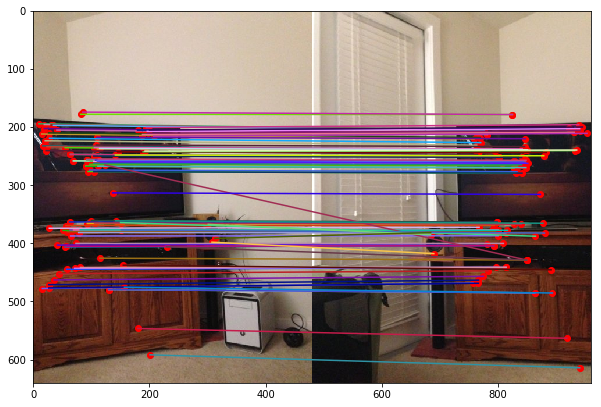

match points after RANSAC with threshold = 1


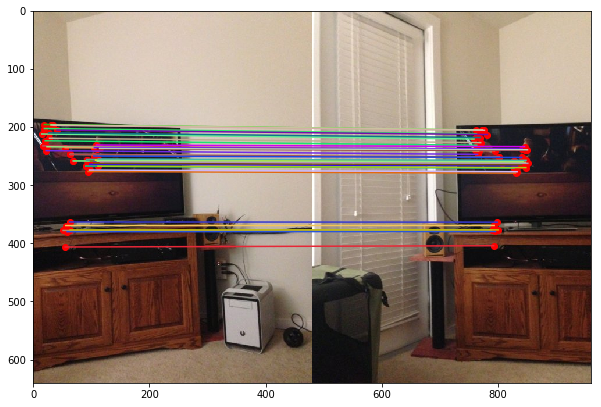

True

In [7]:
img1_path = './data/2.jpg'
img2_path = './data/1.jpg'

line, img1, img2 = match(img1_path, img2_path, ratio = 0.5, show = True)
better_kp1, better_kp2 = ransac(img1, img2, line, error_threshold = 1, show = True)
H = findH(better_kp2, better_kp1)
ifinal = warp(img1, img2, H)
cv2.imwrite('output.jpg', ifinal)

# stitch more images

In [ ]:
import glob

imagesPath = glob.glob('data\\p*.JPG')
output_path = imagesPath[0] # queryImage

for i, img_path in enumerate(imagesPath[1:]):
    print('Start deal with image : {} ...'.format(img_path))

    print('Start match ...')
    line, output, img = match(output_path, img_path, ratio = 0.5, show = True)
    
    print('Start ransac ...')
    better_kp1, better_kp2 = ransac(output, img, line, error_threshold = 1, show = True)

    print('Find H ...')
    H = findH(better_kp2, better_kp1)
    
    print('Start warp ...')
    output = warp(output, img, H)
    
    output_path = 'data\\output{}.jpg'.format(i+1)
    cv2.imwrite(output_path, output)
    